<a href="https://colab.research.google.com/github/Lizzy-Mejia/Data-Science-FemHack-challenge/blob/main/Classification_Requests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=e98387bd2e536c4403ce5a3db9130b42b97c808d72a80c4702297667326745be
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling ch

In [1]:
# Procesado y tratamiento de los datos
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Balanceo del dataset
from imblearn.over_sampling import SMOTEN

# División del dataset
from sklearn.model_selection import train_test_split

# Búsqueda de los mejores parámetros
from sklearn.model_selection import GridSearchCV

# Modelos utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métricas de evaluación
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Otros
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Lectura del dataset
data = pd.read_csv('train.csv')
# Visualización inicial del conjunto de datos
data

,train_idx,title,description,target,creator_name,creator_location,supporters,created_date,banner_image,full_content,victory_flag
0,0,Stop Iran Regime from Chairing U​.​N. Human Ri...,Rights Council 2023 Social Forum. This year's ...,['António Guterres'],UN Watch,"Geneva, Switzerland",80515,10 May 2023,https://assets.change.org/photos/2/ur/wj/vrUrW...,No Joke: The Islamic Republic of Iran has just...,0
1,1,Save Children In Poverty In Syria,Children in Syria are facing extreme poverty. ...,['UNICEF'],Maialen Alawam,"Watertown, MA, United States",23871,25 Jun 2020,https:https://static.change.org/images/default...,Children in Syria are facing extreme poverty. ...,0
2,2,Save Duke Ellington School Of The Arts,NaN,NaN,It’s Me Tivoni,United States,4051,"Nov. 20, 2022",https://assets.change.org/photos/8/ab/hv/DZaBH...,Save Duke Ellington School Of The ArtsTivoni H...,0
3,3,Mobile operators are creating inequality,"In India, after Reliance Jio (a 4G only mobile...","['Telecom Regulatory Authority of India', 'CEL...",Swastik Raj Chauhan,"Ghaziabad, India",350,"Oct 15, 2017",https://assets.change.org/photos/7/by/in/Kzbyi...,"In India, after Reliance Jio (a 4G only mobile...",0
4,4,Grant Military Burial Honors to Women WWII Pilots,"During World War II, a brave group of women jo...",['U.S. Senate'],Tiffany Miller @tiffbmiller,"Walnut Creek, CA, United States",176092,2 Dec 2015,https://assets.change.org/photos/3/lh/jc/TmLhJ...,"During World War II, a brave group of women jo...",1
...,...,...,...,...,...,...,...,...,...,...,...
1960,1960,Justice pour Fortune,Une étudiante togolaise assassinée en France,['Pétition adressée à au Gouvernement Togolais...,Yao KLEGBAZA,Ghana,15341,Date de création 10 déc. 2022,https://assets.change.org/photos/3/im/dw/aLImD...,Une étudiante togolaise assassinée en France,1
1961,1961,100% Clean Renewable Energy by 2030.,"switch to 100% clean renewable energy by 2030,...","['The World', 'Joseph R. Biden', 'Boris Johnso...",Jack B.,"New Mexico, United States",4036,8 Aug 2021,https://assets.change.org/photos/2/nw/hz/dpNwH...,We have less than 7 years until the effects of...,0
1962,1962,Create a Fair and Compassionate UK Immigration...,treated?\nThis petition challenges the U.K. go...,"['Sajid Javid', 'Caroline Nokes', 'Diane Abbott']",D K Thomas,"Salisbury, ENG, United Kingdom",6393,"Jun 4, 2018",https://assets.change.org/photos/6/eo/ir/yUeOi...,"If your dream was to live in another country, ...",0
1963,1963,Approve my Social Security Disability,disability have been denied even though my med...,['Richard Burr'],Cel Layne,"Lynchburg, VA, United States",71938,20 Jan 2016,https://assets.change.org/photos/0/qa/ut/Fnqau...,I WANT TO PERSONALLY THANK EVERY ONE OF YOU FO...,1


In [3]:
# Verificamos cuales son las variables que poseen mas correlación con respecto a la variable de salida
data.corr()['victory_flag'].sort_values()

train_idx       0.023921
supporters      0.046517
victory_flag    1.000000
Name: victory_flag, dtype: float64

In [4]:
# Eliminación de datos que son irrelevantes y que podrían afectar el resultado.
df = data.drop(['train_idx','banner_image','target','creator_name','description','creator_location','created_date','full_content','supporters'], axis=1)

In [5]:
#Validación de la cantidad de ejemplos que posee el dataset segun la variable de salida.
df["victory_flag"].value_counts()

0    1680
1     285
Name: victory_flag, dtype: int64

In [6]:
df_en = df.copy()

In [7]:
from googletrans import Translator

# Crear una instancia del traductor
translator = Translator(service_urls=['translate.google.com'])

# Crear un diccionario para almacenar las traducciones
translations = {}

# Obtener los elementos únicos de la columna
unique_elements = df_en['title'].unique()

# Traducir cada elemento único y agregarlo al diccionario
for element in unique_elements:
    try:
        translation = translator.translate(element, dest='en')
        translations[element] = translation.text
    except Exception as e:
        translations[element] = 'Translation Error'

# Imprimir las traducciones
print(translations)

{'Stop Iran Regime from Chairing U\u200b.\u200bN. Human Rights Council Forum': 'Stop Iran Regime from Chairing UN. Human Rights Council Forum', 'Save Children In Poverty In Syria': 'Save Children In Poverty In Syria', 'Save Duke Ellington School Of The Arts': 'Save Duke Ellington School Of The Arts', 'Mobile operators are creating inequality': 'Mobile operators are creating inequality', 'Grant Military Burial Honors to Women WWII Pilots': 'Grant Military Burial Honors to Women WWII Pilots', "Don't Violate the Charter of Rights": "Don't Violate the Charter of Rights", "Use Chargers' termination fee to provide housing": "Use Chargers' termination fee to provide housing", 'Open a federal investigation into the fatal police shooting of John Crawford III. Release video of shooting.': 'Open a federal investigation into the fatal police shooting of John Crawford III. Release video of shooting.', 'Keep Trans Kids in Sports Aligned With Their Gender Identity': 'Keep Trans Kids in Sports Aligned

In [8]:
# modify all the terms of the data frame by using the previously created dictionary
df_en.replace(translations, inplace = True)
# check translation
df_en.head()

,title,victory_flag
0,Stop Iran Regime from Chairing UN. Human Right...,0
1,Save Children In Poverty In Syria,0
2,Save Duke Ellington School Of The Arts,0
3,Mobile operators are creating inequality,0
4,Grant Military Burial Honors to Women WWII Pilots,1


In [9]:
# Del conjunto de datos general separamos la variable de salida del resto de datos
X_df = df_en.drop("victory_flag", axis=1)
y_df = df_en["victory_flag"].copy()

In [10]:
# https://imbalanced-learn.org/dev/over_sampling.html
# Inicializamos el método de sobremuestreo
from imblearn.over_sampling import SMOTEN
sampler = SMOTEN(random_state=0)
# Le pasamos el dataset
X_smoten, y_smoten = sampler.fit_resample(X_df, y_df)
# Hacemos un nuevo recuento para validar la cantidad de datos por cada caso
no_smoten = y_smoten.sum()
si_smoten = y_smoten.shape[0]- no_smoten
print('Personas que si firmaron:', si_smoten ,'Personas que no firmaron:', no_smoten)
# Visualizamos el dataset equilibrado para ambos casos
X_smoten

Personas que si firmaron: 1680 Personas que no firmaron: 1680


,title
0,Stop Iran Regime from Chairing UN. Human Right...
1,Save Children In Poverty In Syria
2,Save Duke Ellington School Of The Arts
3,Mobile operators are creating inequality
4,Grant Military Burial Honors to Women WWII Pilots
...,...
3355,Bozcaada bays are not for sale!Because #bozcaa...
3356,Translation Error
3357,Translation Error
3358,Translation Error


In [11]:
# Unimos nuevamente la variable de salida al dataset para poder realizar la división de los datos
data_clean= pd.concat([X_smoten, y_smoten], axis=1,sort=True)
# Visualizamos los cambios aplicados
data_clean

,title,victory_flag
0,Stop Iran Regime from Chairing UN. Human Right...,0
1,Save Children In Poverty In Syria,0
2,Save Duke Ellington School Of The Arts,0
3,Mobile operators are creating inequality,0
4,Grant Military Burial Honors to Women WWII Pilots,1
...,...,...
3355,Bozcaada bays are not for sale!Because #bozcaa...,1
3356,Translation Error,1
3357,Translation Error,1
3358,Translation Error,1


In [12]:
# Recuento de casos de ACV en los datos
data_clean[(data_clean['title']=='Translation Error') & (data_clean['victory_flag']==1)]

,title,victory_flag
552,Translation Error,1
556,Translation Error,1
560,Translation Error,1
595,Translation Error,1
599,Translation Error,1
...,...,...
3351,Translation Error,1
3354,Translation Error,1
3356,Translation Error,1
3357,Translation Error,1


In [13]:
# Seleccionamos los datos a eliminar
data_apart=data_clean[data_clean['title']=='Translation Error'].index
# Eliminados los datos seleccionados
data_clean2=data_clean.drop(data_apart)
# Reseteamos el index de la filas
data_clean2.reset_index(drop=True, inplace=True)
# Visualizamos los cambios aplicados
data_clean2

,title,victory_flag
0,Stop Iran Regime from Chairing UN. Human Right...,0
1,Save Children In Poverty In Syria,0
2,Save Duke Ellington School Of The Arts,0
3,Mobile operators are creating inequality,0
4,Grant Military Burial Honors to Women WWII Pilots,1
...,...,...
2251,Bozcaada bays are not for sale!Because #bozcaa...,1
2252,Bozcaada bays are not for sale!Because #bozcaa...,1
2253,Bozcaada bays are not for sale!Because #bozcaa...,1
2254,Bozcaada bays are not for sale!Because #bozcaa...,1


In [14]:
# Definimos un pipeline para limpiar todos los mensajes
# El pipeline realizamos lo siguiente: (1) eliminar signos de putuación, (2) eliminar las stopwords
import string
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Probemos la función que acabamos de crear
df_clean3 = data_clean2['title'].apply(message_cleaning)

In [18]:
print(df_clean3[15])

['Bee', 'killers', 'insecticides', 'derogation']


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer=message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(data_clean2['title'])

In [20]:
feature_names = list(vectorizer.vocabulary_.keys())
print(feature_names)

['Stop', 'Iran', 'Regime', 'Chairing', 'UN', 'Human', 'Rights', 'Council', 'Forum', 'Save', 'Children', 'Poverty', 'Syria', 'Duke', 'Ellington', 'School', 'Arts', 'Mobile', 'operators', 'creating', 'inequality', 'Grant', 'Military', 'Burial', 'Honors', 'Women', 'WWII', 'Pilots', 'Dont', 'Violate', 'Charter', 'Use', 'Chargers', 'termination', 'fee', 'provide', 'housing', 'Open', 'federal', 'investigation', 'fatal', 'police', 'shooting', 'John', 'Crawford', 'III', 'Release', 'video', 'Keep', 'Trans', 'Kids', 'Sports', 'Aligned', 'Gender', 'Identity', 'Indigenous', 'Emoji', 'AU', 'Manifesto', 'da', 'Esperança', 'dignity', 'respect', 'LGBTQIAP', 'population', 'Fibromyalgia', 'recognised', 'Official', 'Disability', 'Rep', 'Ireland', 'Agawam', 'Conservation', 'Commission’s', 'ruling', 'puts', 'Crowleys', 'Horses', 'business', 'recognition', 'Doctor', 'Honoris', 'Causa', 'Economics', 'Iván', 'Duque', 'South', 'Korea', 'Free', 'Sanitary', 'PadsMenstrual', 'Cup', 'Govt', 'India', 'females', 'li

In [21]:
data_clean2.drop(['title'], axis = 1, inplace = True)

In [22]:
data_traduct = pd.DataFrame(reviews_countvectorizer.toarray())

In [23]:
data_clean3 = pd.concat([data_clean2, data_traduct], axis = 1)

In [24]:
data_clean3

,victory_flag,0,1,2,3,4,5,6,7,8,...,4138,4139,4140,4141,4142,4143,4144,4145,4146,4147
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2252,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2253,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2254,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
data_clean3.columns = data_clean3.columns.astype(str)

In [26]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [27]:
# Division del conjunto de datos en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(data_clean3, stratify='victory_flag')

In [28]:
#Verificamos las particiones realizadas
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 1353
Longitud del Validation Set: 451
Longitud del Test Set: 452


In [29]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("victory_flag", axis=1)
y_train = train_set["victory_flag"].copy()

In [30]:
# Conjunto de datos de pruebas
X_val = val_set.drop("victory_flag", axis=1)
y_val = val_set["victory_flag"].copy()

In [31]:
# Conjunto de datos de test
X_test = test_set.drop("victory_flag", axis=1)
y_test = test_set["victory_flag"].copy()

In [32]:
# Pruebas de con diferentes modelos
models = []
models.append(['Logistic Regreesion', LogisticRegression()])
models.append(['SVM', SVC()])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier()])
models.append(['Random Forest', RandomForestClassifier()])
models.append(['Ada Boost', AdaBoostClassifier()])

# Evaluación de los diferentes modelos
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kFold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kFold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()*100.0:,.2f}% ({cv_results.std()*100.0:,.2f}%)")

Logistic Regreesion: 92.02% (2.29%)
SVM: 92.02% (2.29%)
KNeighbors: 91.87% (2.25%)
GaussianNB: 81.60% (3.03%)
BernoulliNB: 91.87% (2.25%)
Decision Tree: 89.36% (1.49%)
Random Forest: 92.24% (2.28%)
Ada Boost: 90.69% (2.59%)


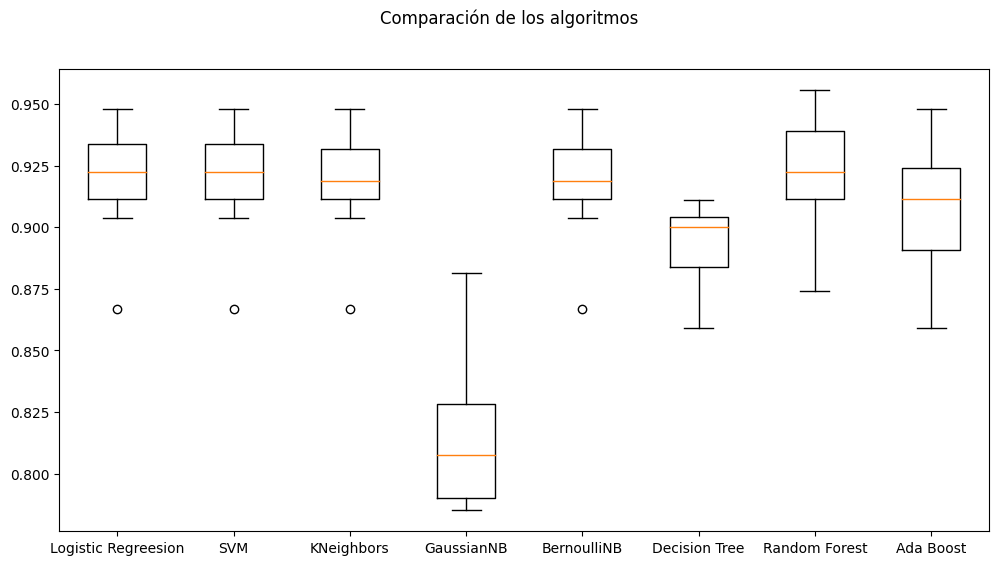

In [33]:
# Gráfica de caja para verificar el rendimiento de los diferentes modelos probados
fig = plt.figure(figsize =(12,6))
fig.suptitle('Comparación de los algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [34]:
# Búsqueda de los mejores parámetros para "Bosques aleatorios"
parameters3 = {"max_depth": [1, 2, 3, None],
              "max_features": [1, 2, 3, "sqrt", "log2"],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy", "log_loss"]
              }

model_RFC = RandomForestClassifier()
kFold = KFold(n_splits=10, random_state=7, shuffle=True)

grid3 = GridSearchCV(estimator=model_RFC, param_grid=parameters3, cv=kFold, return_train_score=True)
grid_result3= grid3.fit(X_train, y_train)

# mejores parámetros
grid_result3.best_params_

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1}

In [90]:
# Entrenamiento y prueba del modelo final
# Inicializamos el modelo
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
modelo_final = RandomForestClassifier(**grid_result3.best_params_)
# Ajuste del modelo
modelo_final.fit(X_train,y_train)

# Realizamos una nueva predición con los datos de prueba
y_pred = modelo_final.predict(X_val)

# Evaluamos el rendimiento del modelo con los datos de prueba
accuracy_score(y_val, y_pred)

0.9157427937915743

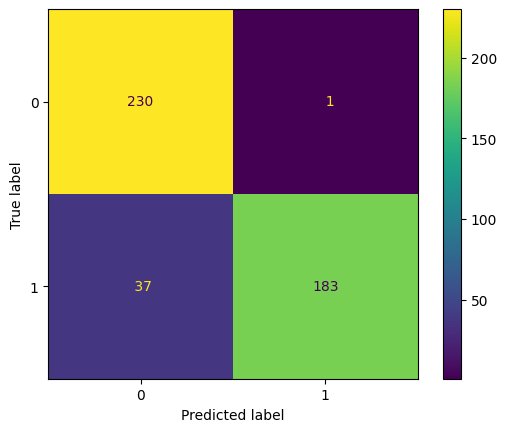

In [91]:
# Resultados de la matriz de confusión con los datos de prueba
ConfusionMatrixDisplay.from_estimator(modelo_final, X_val, y_val, values_format='3g')

In [92]:
# Reporte de los resultados que se obtuvieron con los datos de prueba
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       231
           1       0.99      0.83      0.91       220

    accuracy                           0.92       451
   macro avg       0.93      0.91      0.91       451
weighted avg       0.93      0.92      0.92       451



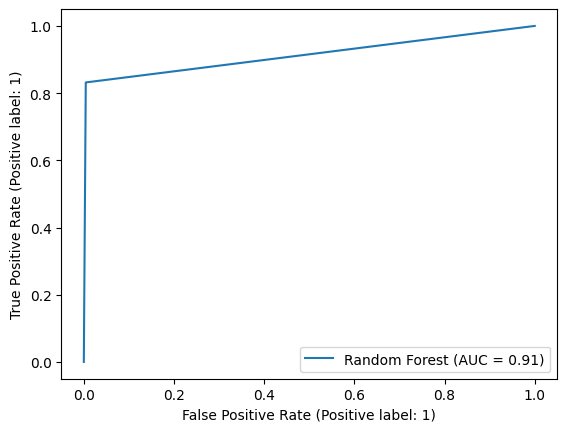

In [93]:
# Curva ROC
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_val, y_pred, name="Random Forest")
plt.show()

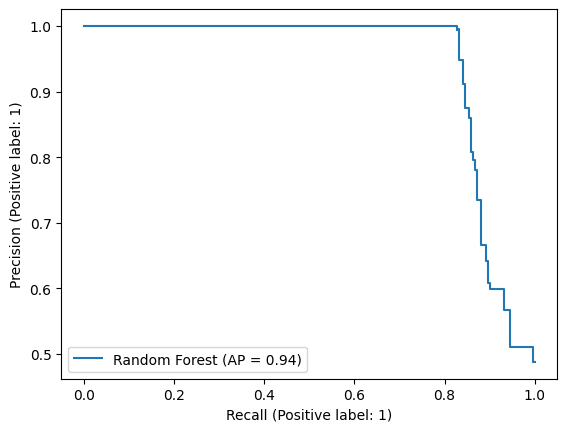

In [94]:
# Curva PR
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(modelo_final, X_val, y_val, name="Random Forest")

In [95]:
# Realizamos una nueva predición con los datos de test
y_pred2 = modelo_final.predict(X_test)

# Evaluamos el rendimiento del modelo con los datos de test
accuracy_score(y_test, y_pred2)

0.9092920353982301

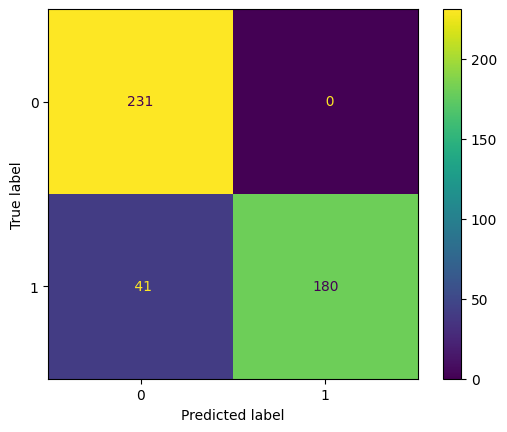

In [96]:
# Resultados de la matriz de confusión con los datos de test
ConfusionMatrixDisplay.from_estimator(modelo_final, X_test, y_test, values_format='3g')

In [97]:
# Reporte de los resultados que se obtuvieron con los datos de test
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       231
           1       1.00      0.81      0.90       221

    accuracy                           0.91       452
   macro avg       0.92      0.91      0.91       452
weighted avg       0.92      0.91      0.91       452



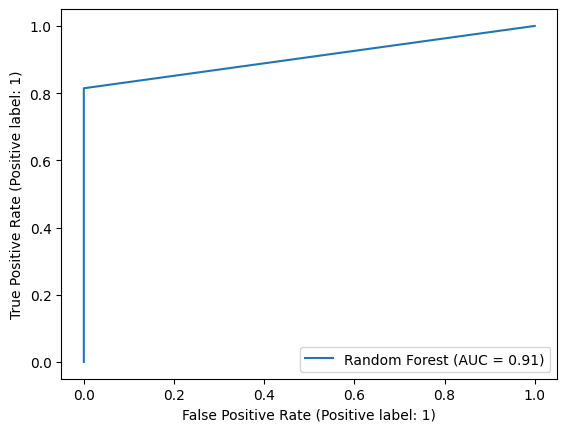

In [98]:
# Curva ROC
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred2, name="Random Forest")
plt.show()

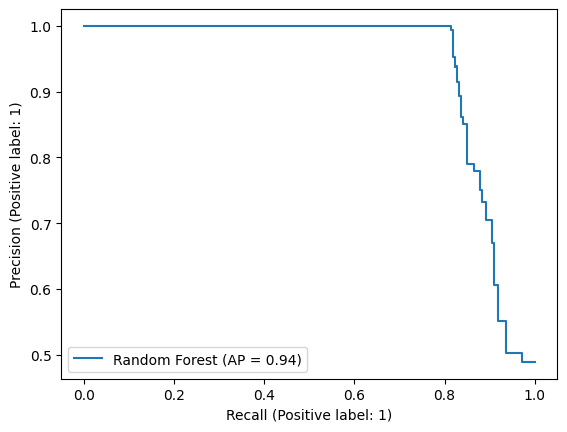

In [99]:
# Curva PR
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(modelo_final, X_test, y_test, name="Random Forest")

In [111]:
# Lectura del dataset de pruebas
data_prueba = pd.read_csv('test.csv')
# Visualización inicial del conjunto de datos
data_prueba

,test_idx,title,description,target,creator_name,creator_location,supporters,created_date,banner_image,full_content
0,0,Get my case heard for neglect,son in another empty labor and delivery room l...,"['Virginia Governor', 'St francis hospital', '...",tyra reyes,"Richmond, VA, United States",149447,"Oct. 26, 2017",https://assets.change.org/photos/3/sq/fl/Klsqf...,On 3/12/17 I was at home talking to my sister ...
1,1,JUSTICE POUR JOE ET DAX: pour une peine exempl...,"Le 13 Février 2018, 3 chiens étaient déposés c...","['Pétition adressée à Nicole Belloubet', 'Cyri...",Daniel MADEIRA,France,53919,Date de création 10 mai 2019,https://assets.change.org/photos/7/xj/js/ONxJJ...,"Le 13 Février 2018, 3 chiens étaient déposés c..."
2,2,Mandatory Course in Mental Health for Highschool,"In any given year, 1 in 5 people in Canada wil...","['The Minister Of Education', 'Halton Catholic...",Jayme Robinson,"Oakville, Canada",30635,"Jun 11, 2018",https://assets.change.org/photos/8/px/bz/oupXB...,"In any given year, 1 in 5 people in Canada wil..."
3,3,Stop coronavirus - call for permanent ban on c...,Français\nрусский \nPlease take action to supp...,"[""National People's Congress (NPC)"", 'WHO', 'O...",ACTAsia Education,United Kingdom,48004,20 Feb 2020,https://assets.change.org/photos/9/fc/zm/cZFCZ...,Français\n\nрусский\n\nPlease take action to s...
4,4,Chiedere alle Nazioni Unite che il 2018 sia l'...,"population?- induced as they are by violence, ...",['Petizione diretta a Assemblea Generale Nazio...,Cristiana Fiamingo,"Università degli Studi di Milano, Italia",436,Data di lancio 27 lug 2017,https://assets.change.org/photos/3/fd/wb/Cjfdw...,[ITA] Se osservate la lista delle annate inter...
...,...,...,...,...,...,...,...,...,...,...
487,487,Restore student privacy,. Lightspeed and GoGaurdian are gross violatio...,['Princeton administratio n'],william alena,United States,123,"Apr. 15, 2021",https://assets.change.org/photos/5/ru/pe/RqRup...,Protecting students from self harm is incredib...
488,488,Petition the International Maritime Organizati...,public support in advance of this meeting will...,['International Maritime Organization (IMO)'],Environmental Investigation Agency,"London, ENG, United Kingdom",89876,10 Nov 2021,https://assets.change.org/photos/4/cf/gq/EsCFG...,"In May 2021, the MV X-Press Pearl spilt 1,680 ..."
489,489,Keep the Arts in Our Schools,Talbot County Public Schools have decided to c...,['Talbot County Public Schools'],Brett Hutchinson,"Easton, MD, United States",4565,"Mar. 29, 2019",https://assets.change.org/photos/5/cl/yx/iPcLy...,Talbot County Public Schools have decided to c...
490,490,Save Adelaide's arts community! Save Flinders ...,Creative Arts (Drama) aka The Drama Centre. Fo...,['artists'],Ren Williams,Australia,8616,"Dec 10, 2020",https://assets.change.org/photos/4/xt/qc/aaXtQ...,Flinders University has made the devastating d...


In [112]:
# Eliminación de datos que son irrelevantes y que podrían afectar el resultado.
df_new = data_prueba.drop(['test_idx','banner_image','target','creator_name','description','creator_location','created_date','full_content','supporters'], axis=1)

In [113]:
# Crear una instancia del traductor
translator = Translator(service_urls=['translate.google.com'])

# Crear un diccionario para almacenar las traducciones
translations = {}

# Obtener los elementos únicos de la columna
unique_elements = df_new['title'].unique()

# Traducir cada elemento único y agregarlo al diccionario
for element in unique_elements:
    try:
        translation = translator.translate(element, dest='en')
        translations[element] = translation.text
    except Exception as e:
        translations[element] = 'Translation Error'

# Imprimir las traducciones
print(translations)

{'Get my case heard for neglect': 'Get my case heard for neglect', 'JUSTICE POUR JOE ET DAX: pour une peine exemplaire !': 'Justice for Joe and Dax: for an exemplary sentence!', 'Mandatory Course in Mental Health for Highschool': 'Mandatory Course in Mental Health for High School', 'Stop coronavirus - call for permanent ban on commercial wildlife breeding, markets & trade': 'Stop coronavirus - call for permanent ban on commercial wildlife breeding, markets & trade', "Chiedere alle Nazioni Unite che il 2018 sia l'ANNO INTERNAZIONALE DELLE MIGRAZIONI": 'Ask the United Nations that 2018 is the international year of migration', 'Save Patients’ Rights': 'Save Patients’ Rights', 'Stop wrecking our climate - ditch plans to build the UK’s biggest gas plant': 'Stop wrecking our climate - ditch plans to build the UK’s biggest gas plant', 'STOP SEXUAL VIOLENCE AGAINST WOMEN IN CHILE': 'STOP SEXUAL VIOLENCE AGAINST WOMEN IN CHILE', 'Inequality in Schools': 'Inequality in Schools', 'Water Conservat

In [114]:
# modify all the terms of the data frame by using the previously created dictionary
df_new.replace(translations, inplace = True)
# check translation
df_new.head()


,title
0,Get my case heard for neglect
1,Justice for Joe and Dax: for an exemplary sent...
2,Mandatory Course in Mental Health for High School
3,Stop coronavirus - call for permanent ban on c...
4,Ask the United Nations that 2018 is the intern...


In [115]:
# Seleccionamos los datos a eliminar
data_apart2=df_new[df_new['title']=='Translation Error'].index
# Eliminados los datos seleccionados
df_new2=df_new.drop(data_apart2)
# Reseteamos el index de la filas
df_new2.reset_index(drop=True, inplace=True)
# Visualizamos los cambios aplicados
df_new2


,title
0,Get my case heard for neglect
1,Justice for Joe and Dax: for an exemplary sent...
2,Mandatory Course in Mental Health for High School
3,Stop coronavirus - call for permanent ban on c...
4,Ask the United Nations that 2018 is the intern...
...,...
486,Call for Emergency Medical Care for Children S...
487,Restore student privacy
488,Petition the International Maritime Organizati...
489,Keep the Arts in Our Schools


In [149]:
#vectorizer = CountVectorizer(analyzer=message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(df_new2['title'])

In [150]:
feature_names = list(vectorizer.vocabulary_.keys())
print(feature_names)

['Get', 'case', 'heard', 'neglect', 'Justice', 'Joe', 'Dax', 'exemplary', 'sentence', 'Mandatory', 'Course', 'Mental', 'Health', 'High', 'School', 'Stop', 'coronavirus', 'call', 'permanent', 'ban', 'commercial', 'wildlife', 'breeding', 'markets', 'trade', 'Ask', 'United', 'Nations', '2018', 'international', 'year', 'migration', 'Save', 'Patients’', 'Rights', 'wrecking', 'climate', 'ditch', 'plans', 'build', 'UK’s', 'biggest', 'gas', 'plant', 'STOP', 'SEXUAL', 'VIOLENCE', 'WOMEN', 'CHILE', 'Inequality', 'Schools', 'Water', 'Conservation', 'CP', 'learn', 'French', 'Bring', 'Back', 'Trans', 'Healthcare', 'Remove', 'police', 'nine', 'public', 'housing', 'buildings', 'Set', 'Consistent', 'Punishment', 'Guidelines', 'NFL', 'Players', 'Commit', 'Violence', 'Women', 'Change', 'New', 'Zealands', 'immigration', 'law', 'recognise', 'overseas', 'hospitality', 'staffs', 'contribution', 'Lets', 'save', 'tire', 'school', 'PalestineTheTyreschool', 'Note', 'repudiation', 'burning', 'Pantanal', 'Amazon'

In [151]:
df_new3 = pd.DataFrame(reviews_countvectorizer.toarray())

In [152]:
df_new3

,0,1,2,3,4,5,6,7,8,9,...,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
df_new3.columns = df_new3.columns.astype(str)

In [154]:
# Realizamos una nueva predición con los datos de prueba
y_pred_prueba = modelo_final.predict(df_new3)

ValueError: ignored

In [148]:
y_pred_prueba

array([0, 0, 0, ..., 1, 1, 1])

In [137]:
# Guardamos los resultados de las predicciones
pd.DataFrame(y_pred_prueba, columns=['target'], index=df_new3.index).to_json("predictions.json", orient="columns", index=True)